In [48]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

data_path=os.path.join(path,'Housing.csv')


Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1


#Loading the dataset

In [49]:
#Load the dataset
df=pd.read_csv(data_path)
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


#Pre processing


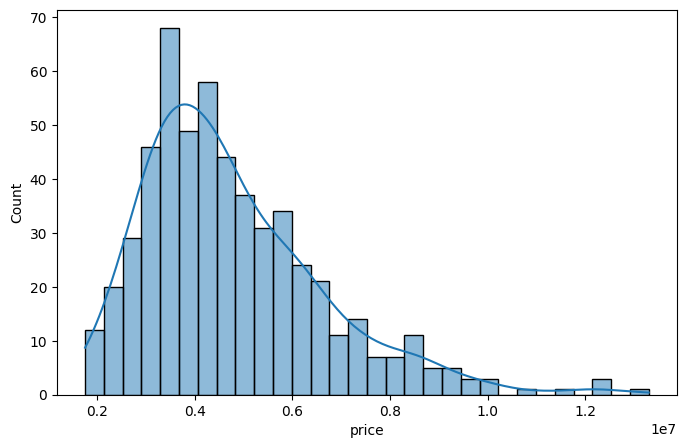

In [50]:

#VISULIZATION
plt.figure(figsize=(8,5))
sns.histplot(df['price'], kde=True, bins=30)
plt.show()

#Data cleaning


In [51]:
#As already verified there's no missing data
missing_values = df.isnull().sum().sort_values(ascending=False)
print ("Missing values in every line" , missing_values)
df.isnull().sum().sum()

Missing values in every line price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


np.int64(0)

#Feature Engineering

In [52]:
#Encode yes/no colomn
yes_no_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in yes_no_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

#Encode furnishing status
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [53]:
#Creating new variables to get more insight
#total_rooms
df['total_rooms']=df['bedrooms']+df['bathrooms']
#Luxury score
df['luxury_score']= (df['airconditioning'] +
    df['hotwaterheating'] +
    df['basement'] +
    df['guestroom'] +
    df['prefarea'] +
    df['parking'] * 0.5 +
    df['stories'] * 0.3
)
#area per room
df['area_per_room'] = df['area'] / df['total_rooms']
#4 is_furnished
df['is_furnished'] = df['furnishingstatus_unfurnished'].apply(lambda x: 0 if x == True else 1)

df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,total_rooms,luxury_score,area_per_room,is_furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False,6,3.9,1236.666667,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False,8,3.7,1120.000000,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False,5,3.6,1992.000000,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False,6,5.1,1250.000000,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False,5,4.6,1484.000000,1


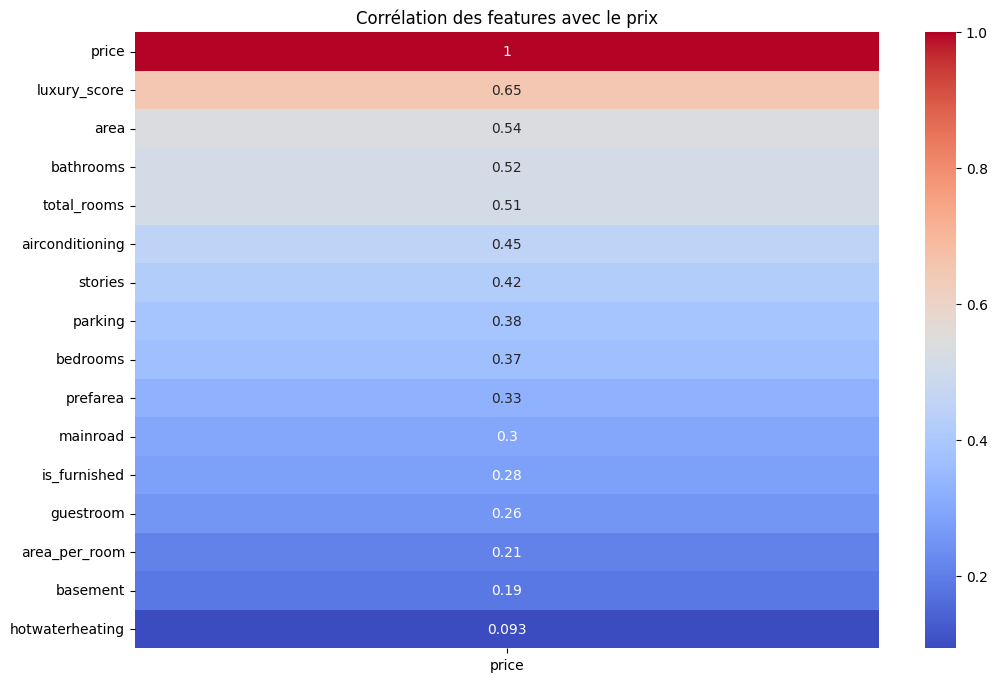

In [54]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calcul de la matrice de corrélation
corr_matrix = df[num_cols].corr()

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Corrélation des features avec le prix')
plt.show()

#Modelisation

In [55]:
target='price'
features= ['luxury_score','area','bathrooms','total_rooms']
X= df[features]
y= df[target]
#train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Shape X_train:", X_train_scaled.shape)
print("Shape X_test:", X_test_scaled.shape)


Shape X_train: (436, 4)
Shape X_test: (109, 4)


In [56]:


model = LinearRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)


RMSE : 1435757.0199447994
R² : 0.5921714171832164
        Feature    Coefficient
0  luxury_score  748818.558339
1          area  550677.918964
2     bathrooms  489006.410513
3   total_rooms  176347.411486


#Visulization


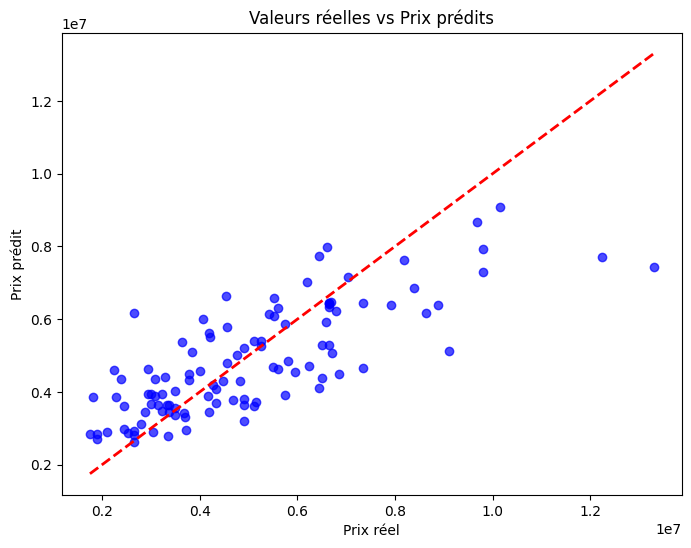

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # ligne idéale
plt.xlabel('Prix réel')
plt.ylabel('Prix prédit')
plt.title('Valeurs réelles vs Prix prédits')
plt.show()

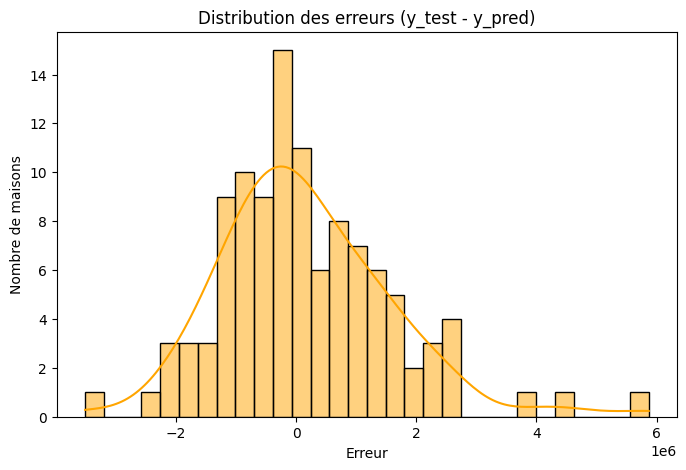

In [58]:
errors = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.title('Distribution des erreurs (y_test - y_pred)')
plt.xlabel('Erreur')
plt.ylabel('Nombre de maisons')
plt.show()

/tmp/ipython-input-1208192086.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients.sort_values(by='Coefficient', ascending=False), palette='viridis')


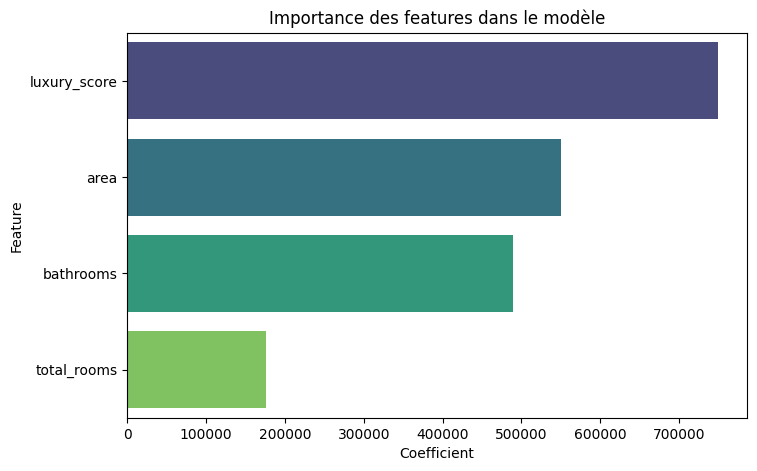

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.sort_values(by='Coefficient', ascending=False), palette='viridis')
plt.title('Importance des features dans le modèle')
plt.show()